In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from kernels import K_classical, K_simple_RX, K_phi_RX, K_layered, K_L_tower, K_L_prod, K_L_cheb
import pennylane as qml
from optim import multivalued_mmr_DE, mmr_DE


In [2]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer.noise import NoiseModel

backend = GenericBackendV2(num_qubits=8)
noise_model = NoiseModel.from_backend(backend)

In [7]:
kernels = {
    'RBF': K_classical(0.20),
    '2L-prod': K_L_prod(N=8, n_layers=2),
    '2L-tower': K_L_tower(N=8, n_layers=2),
    '2L-cheb' :K_L_cheb(N=8, n_layers=2),
    '1L-prod': K_L_prod(N=8, n_layers=1),
    '1L-tower': K_L_tower(N=8, n_layers=1),
    '1L-cheb' :K_L_cheb(N=8, n_layers=1),
    'K_XYZ': K_layered(N=8, n_layers=3),
}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in arccos
  return f_raw(*args, **kwargs)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

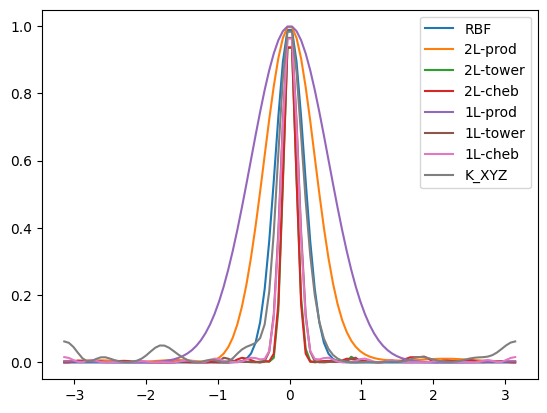

In [3]:
# compare the kernels
xs = np.linspace(-np.pi, np.pi, 100)

for label, kernel in kernels.items():
    plt.plot(xs, [kernel(x, 0) for x in tqdm(xs)], label=label)

plt.legend()
plt.show()

In [4]:
def make_DE(llambda, kk):
    def df_dx(x, f, l, k):
        return -l * k * f -l * np.exp(-l * k * x) * np.sin(l * x)
    
    def DE(x, f, dfdx):
        return dfdx - df_dx(x, f, llambda, kk)
    
    def f_sol(x):
        return np.exp(-llambda * kk * x) * np.cos(llambda * x)
    
    return DE, f_sol

In [25]:
llambda = 20
kk = 0.1

DE, sol = make_DE(llambda, kk)

x = np.linspace(0, 1, 21)
y = x
results = {}

In [26]:
for label, kernel in tqdm(kernels.items()):
    print(f'Running {label}')
    f_sol = mmr_DE(DE=DE, data=[x, y], x0=0.0, f0=1.0, k=kernel)

    results[label] = [f_sol(x) for x in xs]
    
    #plt.plot(xs, results[label], label=label)
    #plt.show()


  0%|          | 0/9 [00:00<?, ?it/s]

Running RBF
Loss:  889.042796824137
Loss:  822.7715552912995
Loss:  790.5664063027874
Loss:  732.619138582493
Loss:  622.7072809337178
Loss:  433.877112296699
Loss:  248.28111997690638
Loss:  240.60650055605004
Loss:  169.36608699799407
Loss:  56.241028340680494
Loss:  1.1613061853644695
Loss:  1.1613040859092407
Loss:  1.1613009063435895
Loss:  1.1612996988772775
Loss:  0.9590673977580654
Loss:  0.6002299663911891
Loss:  0.14838467282147416
Loss:  0.14838465022274513
Optimization terminated successfully.
         Current function value: 0.148385
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 1450
         Hessian evaluations: 0
Running 2L-prod
Loss:  945.3999119199493
Loss:  872.8384542494202
Loss:  852.3660647821431
Loss:  818.4324420799512
Loss:  793.5910153660454
Loss:  793.1367906437989
Loss:  537.0336178323575
Loss:  362.0310094982797
Loss:  362.03100817168786
Optimization terminated successfully.
         Current function value: 362.0310

/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in add
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


         Current function value: nan
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 880
         Hessian evaluations: 0
Running 1L-prod
Loss:  947.4774592241382
Loss:  921.5313788884741
Loss:  887.5295563479823
Loss:  883.5565334813974
Loss:  876.3688682469786
Loss:  864.9547755683013
Loss:  859.3821388311919
Loss:  859.3819816495484
Loss:  859.3819773563141
Loss:  820.3173910047701
Loss:  796.9889266264673
Loss:  796.9889265135108
Optimization terminated successfully.
         Current function value: 796.988927
         Iterations: 12
         Function evaluations: 24
         Gradient evaluations: 120
         Hessian evaluations: 0
Running 1L-tower
Loss:  490.65460571403275
Loss:  82.31276699016263
Loss:  60.702454953419306
Loss:  29.603320697181886
Loss:  10.756973695439372
Loss:  0.295671967380122
Loss:  0.2956567512580583
Loss:  0.2869580308478793
Loss:  0.28022277328933365
Loss:  0.21632993780479234
Loss:  0.10654349598689794
Loss:  0.0002

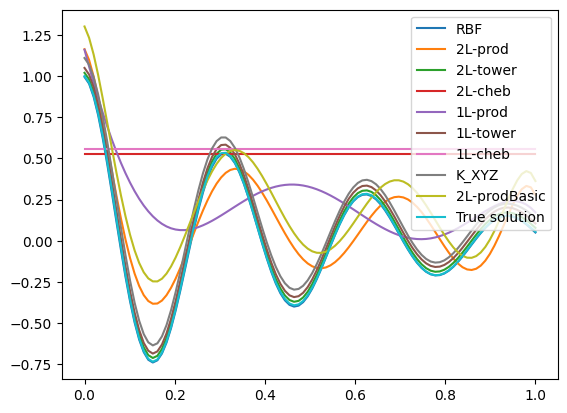

In [27]:
for i, (label, result) in enumerate(results.items()):
    plt.plot(xs, np.array(result) + i * 0.01, label=label)
    
plt.plot(xs, sol(xs), label='True solution')
plt.legend()
plt.savefig('data/mmr_linear_DE_results.png')

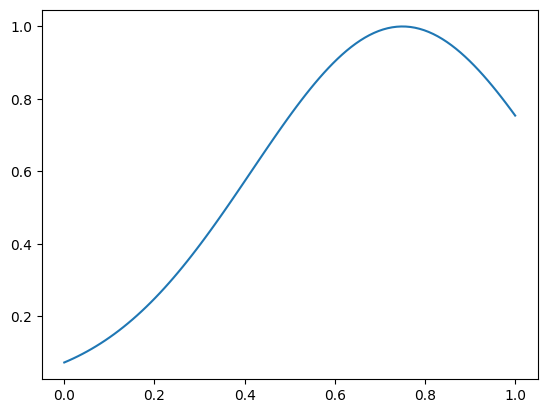

In [19]:
k = kernels["2L-prod"]
xs = np.linspace(0, 1, 100)
plt.plot(xs, [k(0.75, x) for x in xs])

In [20]:
f_sol = mmr_DE(DE=DE, data=[x, y], x0=0.0, f0=1.0, k=k)

Loss:  945.3999119199493
Loss:  872.8384542494202
Loss:  852.3660647821431
Loss:  818.4324420799512
Loss:  793.5910153660454
Loss:  793.1367906437989
Loss:  537.0336178323575
Loss:  362.0310094982797
Loss:  362.03100817168786
Optimization terminated successfully.
         Current function value: 362.031008
         Iterations: 9
         Function evaluations: 14
         Gradient evaluations: 181
         Hessian evaluations: 0


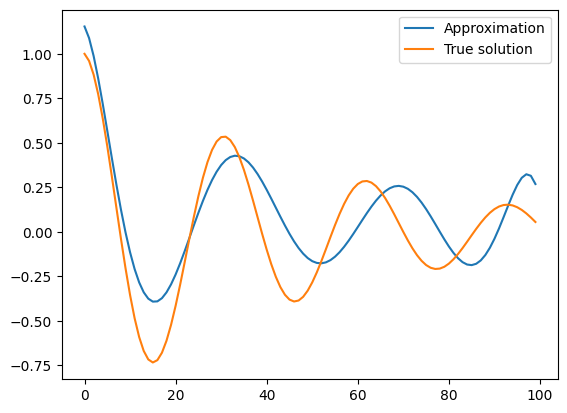

In [22]:
xs = np.linspace(0, 1, 100)
plt.plot([f_sol(x) for x in xs], label='Approximation')
plt.plot([sol(x) for x in xs], label='True solution')
plt.legend()
plt.show()